In [153]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
import math
import torch.nn as nn

In [6]:
env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


In [7]:
class QNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(QNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

### 经验池

In [8]:
class ReplayBuffer:
    def __init__(self, max_size: int, obs_dim: int, batch_size: int = 32):
        self._obs_buf = np.zeros([max_size, obs_dim], dtype=np.float32)
        self._act_buf = np.zeros([max_size], dtype=np.float32)
        self._reward = np.zeros([max_size], dtype=np.float32)
        self._next_obs_buf = np.zeros([max_size, obs_dim], dtype=np.float32)
        self._done = np.zeros([max_size], dtype=np.float32)
        
        self._index = 0
        self._size = 0
        self._max_size = max_size
        self._batch_size = batch_size
        
    def store(self, obs: np.ndarray, act: np.ndarray, rew: float, next_obs: np.ndarray, done: bool):
        self._obs_buf[self._index] = obs
        self._act_buf[self._index] = act
        self._reward[self._index] = rew
        self._next_obs_buf[self._index] = next_obs
        self._done[self._index] = done
        self._index = (self._index + 1) % self._max_size
        self._size = min(self._size + 1, self._max_size)
        
    def __len__(self) -> int:
        return self._size
    
    def sample(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self._size, size=self._batch_size, replace=False)
        return dict(obs=self._obs_buf[idxs],
                    acts=self._act_buf[idxs],
                    rews=self._reward[idxs],
                    next_obs=self._next_obs_buf[idxs],
                    done=self._done[idxs])

In [248]:
# 在Q上不断更新参数，并利用它进行采样
Q = QNetwork(obs_dim, action_dim).to(device)
#
optimizer = optim.Adam(Q.parameters(), lr=0.0001)

In [249]:
gamma = 0.98
seed = 3
max_buffer = 1000
buffer = ReplayBuffer(max_buffer, obs_dim, batch_size = 32)

max_buffer = 1000
epsilon = 0.9
def select_action(state, explore = True):
    # 选择动作，有0.2的概率进行随机探索
    if explore and np.random.random() < epsilon:
        return env.action_space.sample()
    
    # 有0.8的概率从当前训练的Q函数中，预测所有可能动作的Q值
    with torch.no_grad():
        q_value = Q(torch.FloatTensor(state).to(device))
        action = q_value.argmax().detach().cpu().item()
        return action
    
scores = []
losses = []
steps = []
#假设要跑100幂
epoch = 3000
while True:
    if epoch <= 0:
        break
    
    epoch -= 1
    score = 0
    '''使用如下方式时，state的类型是list，否则是一个array'''
    state, _ = env.reset()
    
    step = 0
    while True:
        '''这里代理选择一个动作来执行'''
        action = select_action(state)
        '''得到下一个状态,构成(s,a,r,s')'''
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        buffer.store(state, action, reward, next_state, done)
        score += reward
        step += 1
        
        if len(buffer) >= max_buffer:
            samples = buffer.sample()
            s = torch.FloatTensor(samples['obs']).to(device)
            a = torch.LongTensor(samples['acts']).reshape(-1, 1).to(device)
            r = torch.FloatTensor(samples['rews']).reshape(-1, 1).to(device)
            next_s = torch.FloatTensor(samples['next_obs']).to(device)
            dones = torch.LongTensor(samples['done']).reshape(-1, 1).to(device)
            '''
            这里可以计算Q_*(s, A)，以及Q_*(s', A),然后用TD算法，逼近Q_*
            '''
            q_value = Q(torch.FloatTensor(s).to(device)).gather(1, a)

            value = Q(torch.FloatTensor(next_s).to(device))
            next_q_value = value.max(1, keepdim=True).values
            
            mask = 1 - dones
#             print('value:', value, 'mask:',mask, 'q_value:', q_value, 'next_q_value:', next_q_value)
            target = r + gamma * next_q_value * mask

    #         print(q_value, target, q_value.shape, target.shape)
            loss = F.smooth_l1_loss(q_value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epsilon = 0.05 + (0.9 - 0.05)*math.exp(-1.0 * step_done / max_buffer)
            step_done += 1
        
        if done or step > 500:
            scores.append(score)
            steps.append(step)
            break
            
        state = next_state

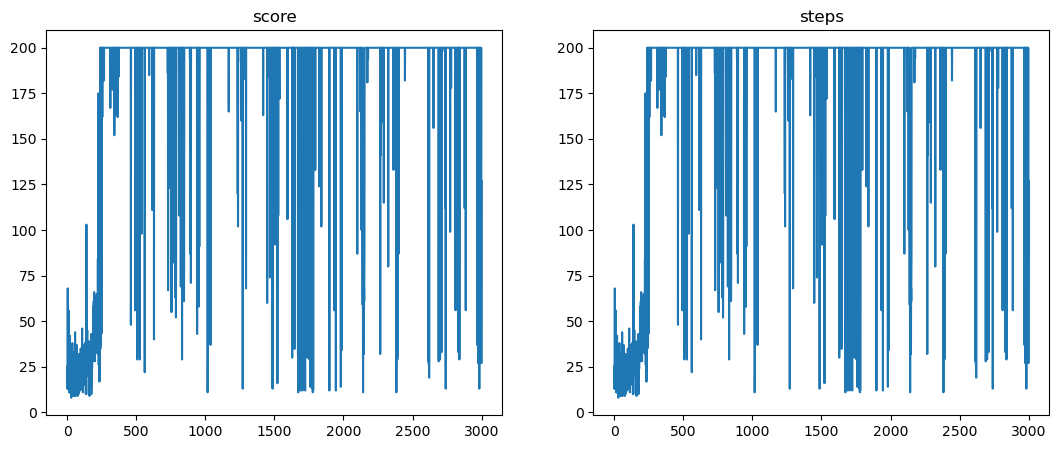

In [250]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
# plt.subplot(133)
# plt.title('epsilons')
# plt.plot(epsilons)
plt.show()

In [251]:
# 观察效果
def test():
    dvideo_env = gym.wrappers.RecordVideo(env, video_folder='.')
    state, _ = dvideo_env.reset(seed=seed)
    done = False
    score = 0
    step = 0
    while not done and step < 200:
        action = select_action(state, False)
        next_state, reward, done, truncated, _ = dvideo_env.step(action)

        state = next_state
        score += reward
        step +=1

    print("score: ", score, "step:", step)
    dvideo_env.close()
    
test()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/webberg/workspace/code/reinforce_learning/rainbow folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/webberg/workspace/code/reinforce_learning/rainbow/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/webberg/workspace/code/reinforce_learning/rainbow/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/webberg/workspace/code/reinforce_learning/rainbow/rl-video-episode-0.mp4
score:  200.0 step: 200


### 使用Q_target

In [263]:
Q = QNetwork(obs_dim, action_dim).to(device)
#
optimizer = optim.Adam(Q.parameters(), lr=0.0001)
# 在Q‘上计算状态价值,用于评估当前学习结果好坏趋势
Q_dot = QNetwork(obs_dim, action_dim).to(device)
Q_dot.load_state_dict(Q.state_dict())
Q_dot.eval()

QNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [264]:
gamma = 0.98
seed = 3
max_buffer = 1000
buffer = ReplayBuffer(max_buffer, obs_dim, batch_size = 32)

max_buffer = 1000
epsilon = 0.9
def select_action(state, explore = True):
    # 选择动作，有0.2的概率进行随机探索
    if explore and np.random.random() < epsilon:
        return env.action_space.sample()
    
    # 有0.8的概率从当前训练的Q函数中，预测所有可能动作的Q值
    with torch.no_grad():
        q_value = Q(torch.FloatTensor(state).to(device))
        action = q_value.argmax().detach().cpu().item()
        return action
    
scores = []
losses = []
steps = []
#假设要跑100幂
epoch = 2000

C = 100
while True:
    if epoch <= 0:
        break
    
    epoch -= 1
    score = 0
    '''使用如下方式时，state的类型是list，否则是一个array'''
    state, _ = env.reset()
    
    step = 0
    while True:
        '''这里代理选择一个动作来执行'''
        action = select_action(state)
        '''得到下一个状态,构成(s,a,r,s')'''
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        buffer.store(state, action, reward, next_state, done)
        score += reward
        step += 1
        
        if len(buffer) >= max_buffer:
            samples = buffer.sample()
            s = torch.FloatTensor(samples['obs']).to(device)
            a = torch.LongTensor(samples['acts']).reshape(-1, 1).to(device)
            r = torch.FloatTensor(samples['rews']).reshape(-1, 1).to(device)
            next_s = torch.FloatTensor(samples['next_obs']).to(device)
            dones = torch.LongTensor(samples['done']).reshape(-1, 1).to(device)
            '''
            这里可以计算Q_*(s, A)，以及Q_*(s', A),然后用TD算法，逼近Q_*
            '''
            q_value = Q(torch.FloatTensor(s).to(device)).gather(1, a)

#             value = Q(torch.FloatTensor(next_s).to(device))
            value = Q_dot(torch.FloatTensor(next_s).to(device))
            next_q_value = value.max(1, keepdim=True).values
            
            mask = 1 - dones
#             print('value:', value, 'mask:',mask, 'q_value:', q_value, 'next_q_value:', next_q_value)
            target = r + gamma * next_q_value * mask

    #         print(q_value, target, q_value.shape, target.shape)
            loss = F.smooth_l1_loss(q_value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if step_done % C == 0:
                Q_dot.load_state_dict(Q.state_dict())
                
            epsilon = 0.05 + (0.9 - 0.05)*math.exp(-1.0 * step_done / max_buffer)
            step_done += 1
        
        if done or step > 500:
            scores.append(score)
            steps.append(step)
            break
            
        state = next_state

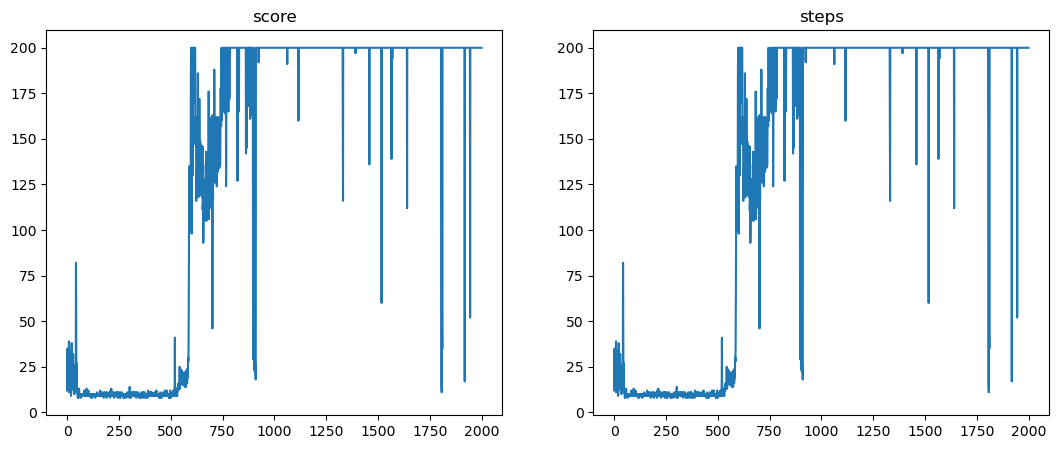

In [265]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
# plt.subplot(133)
# plt.title('epsilons')
# plt.plot(epsilons)
plt.show()

### 优先经验池

In [ ]:
class PriorReplayBuffer(ReplayBuffer):
    def __init__(self, max_buffer, obs_dim, batch_size):
        super(PriorReplayBuffer, self).__init__(max_buffer, obs_dim, batch_size)